In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

In [2]:
merged_df = pd.read_csv('/Users/zoohunn/Desktop/비어플/비어플[의료]/가공한데이터/merged_df.csv')
merged_df

,sample,AJCC_Stage_nature2012,Age_at_Initial_Pathologic_Diagnosis_nature2012,CN_Clusters_nature2012,Converted_Stage_nature2012,Days_to_Date_of_Last_Contact_nature2012,ER_Status_nature2012,Gender_nature2012,HER2_Final_Status_nature2012,Metastasis_Coded_nature2012,...,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,pan.samplesID_y,cancer.type_y,Subtype_mRNA_y,Subtype_Selected_y
0,TCGA-3C-AAAU-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,4047.0,1.0,1808.0,1,1808.0,TCGA-3C-AAAU-01,BRCA,LumA,BRCA.LumA
1,TCGA-3C-AALI-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,4005.0,0.0,4005.0,0,4005.0,TCGA-3C-AALI-01,BRCA,Her2,BRCA.Her2
2,TCGA-3C-AALJ-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1474.0,0.0,1474.0,0,1474.0,TCGA-3C-AALJ-01,BRCA,LumB,BRCA.LumB
3,TCGA-3C-AALK-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1448.0,NaN,NaN,0,1448.0,TCGA-3C-AALK-01,BRCA,LumA,BRCA.LumA
4,TCGA-4H-AAAK-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,348.0,0.0,348.0,0,348.0,TCGA-4H-AAAK-01,BRCA,LumA,BRCA.LumA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1209,TCGA-WT-AB44-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,883.0,0.0,883.0,0,883.0,TCGA-WT-AB44-01,BRCA,LumA,BRCA.LumA
1210,TCGA-XX-A899-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,467.0,0.0,467.0,0,467.0,TCGA-XX-A899-01,BRCA,LumA,BRCA.LumA
1211,TCGA-XX-A89A-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,488.0,0.0,488.0,0,488.0,TCGA-XX-A89A-01,BRCA,LumA,BRCA.LumA
1212,TCGA-Z7-A8R5-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,3287.0,NaN,NaN,1,181.0,TCGA-Z7-A8R5-01,BRCA,LumA,BRCA.LumA


In [3]:
# OS, OS.time 결측치 존재 확인 -> 결측지 없음
print(merged_df['OS.time'].value_counts(dropna=False).sort_index(ascending=True))
print(merged_df['OS'].value_counts(dropna=False).sort_index(ascending=True))

OS.time
0.0       13
1.0        2
5.0        3
7.0        1
8.0        1
          ..
7777.0     1
8008.0     1
8391.0     1
8556.0     1
8605.0     1
Name: count, Length: 828, dtype: int64
OS
0    1016
1     198
Name: count, dtype: int64


In [4]:
sorafenib = pd.read_csv('/Users/zoohunn/Desktop/서은 모델링/REFAMETINIB/REFAMETINIB_predictions.csv')

# TCGA ID 점(.)을 대시(-)로 바꾸기
sorafenib['TCGA_ID'] = sorafenib['TCGA_ID'].str.replace('.', '-', regex=False)

# 그 다음 대문자/공백 제거도 적용
sorafenib['TCGA_ID'] = sorafenib['TCGA_ID'].str.upper().str.strip()
merged_df['sample'] = merged_df['sample'].str.upper().str.strip()

In [5]:
merged_data_final = pd.merge(
    merged_df, 
    sorafenib[['TCGA_ID', 'pred']], 
    left_on='sample', 
    right_on='TCGA_ID', 
    how='inner'
)
merged_data_final.head()

,sample,AJCC_Stage_nature2012,Age_at_Initial_Pathologic_Diagnosis_nature2012,CN_Clusters_nature2012,Converted_Stage_nature2012,Days_to_Date_of_Last_Contact_nature2012,ER_Status_nature2012,Gender_nature2012,HER2_Final_Status_nature2012,Metastasis_Coded_nature2012,...,DFI,DFI.time,PFI,PFI.time,pan.samplesID_y,cancer.type_y,Subtype_mRNA_y,Subtype_Selected_y,TCGA_ID,pred
0,TCGA-3C-AAAU-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1808.0,1,1808.0,TCGA-3C-AAAU-01,BRCA,LumA,BRCA.LumA,TCGA-3C-AAAU-01,0
1,TCGA-A1-A0SG-01,Stage IIB,61.0,4.0,Stage IIB,433.0,Positive,FEMALE,Negative,Negative,...,0.0,434.0,0,434.0,TCGA-A1-A0SG-01,BRCA,LumA,BRCA.LumA,TCGA-A1-A0SG-01,0
2,TCGA-A1-A0SP-01,Stage IIA,40.0,NaN,Stage IIA,583.0,Negative,FEMALE,Negative,Negative,...,0.0,584.0,0,584.0,TCGA-A1-A0SP-01,BRCA,Basal,BRCA.Basal,TCGA-A1-A0SP-01,1
3,TCGA-A2-A04T-01,Stage IIA,62.0,1.0,Stage IIA,2246.0,Negative,FEMALE,Negative,Negative,...,0.0,2246.0,0,2246.0,TCGA-A2-A04T-01,BRCA,Basal,BRCA.Basal,TCGA-A2-A04T-01,1
4,TCGA-A2-A0CM-01,Stage IIA,40.0,4.0,Stage IIA,754.0,Negative,FEMALE,Negative,Negative,...,1.0,382.0,1,382.0,TCGA-A2-A0CM-01,BRCA,Basal,BRCA.Basal,TCGA-A2-A0CM-01,1


### 전체적인 확인

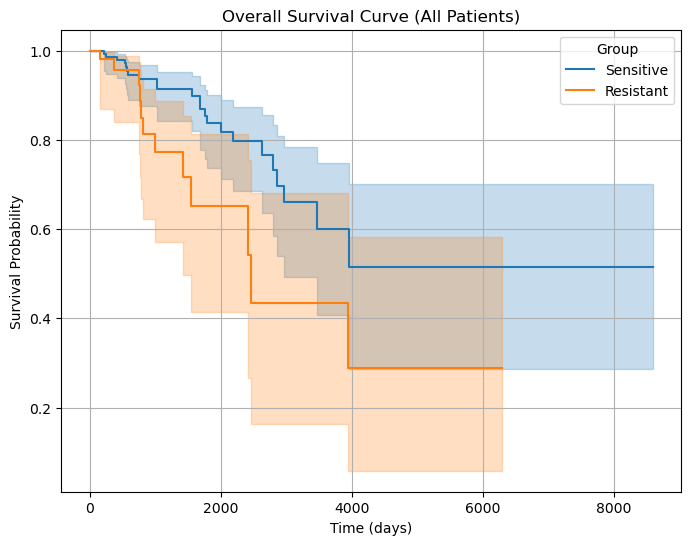

Log-rank test p-value: 0.0142


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# 필요한 변수만 추출 & 결측 제거
survival_data = merged_data_final[['OS.time', 'OS', 'pred']].dropna()

# 민감군과 저항군 나누기
sensitive = survival_data[survival_data['pred'] == 1]
resistant = survival_data[survival_data['pred'] == 0]

# Kaplan-Meier 곡선
kmf = KaplanMeierFitter()

plt.figure(figsize=(8,6))

# 민감군
kmf.fit(sensitive['OS.time'], event_observed=sensitive['OS'], label='Sensitive')
ax = kmf.plot_survival_function(ci_show=True)

# 저항군
kmf.fit(resistant['OS.time'], event_observed=resistant['OS'], label='Resistant')
kmf.plot_survival_function(ax=ax, ci_show=True)

plt.title('Overall Survival Curve (All Patients)')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.legend(title='Group')
plt.grid(True)
plt.show()

# Log-rank 검정
results = logrank_test(
    sensitive['OS.time'], resistant['OS.time'],
    event_observed_A=sensitive['OS'], event_observed_B=resistant['OS']
)

print(f'Log-rank test p-value: {results.p_value:.4f}')

### 병기별


Stage: Stage IIB


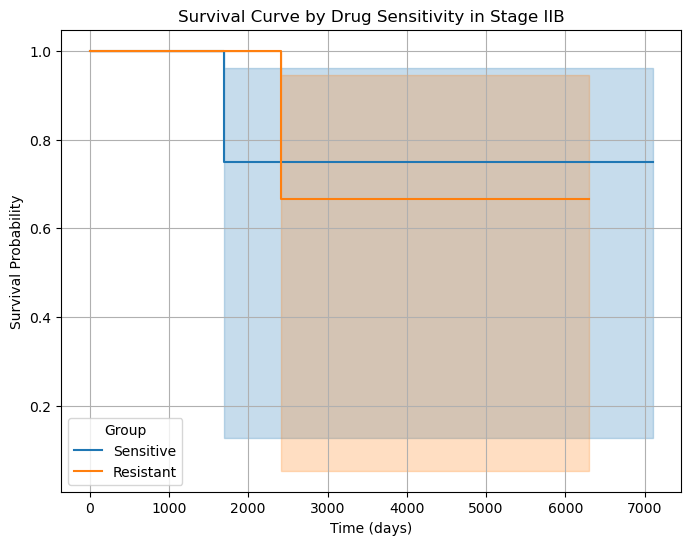

  Log-rank test p-value: 0.9673

Stage: Stage IIA


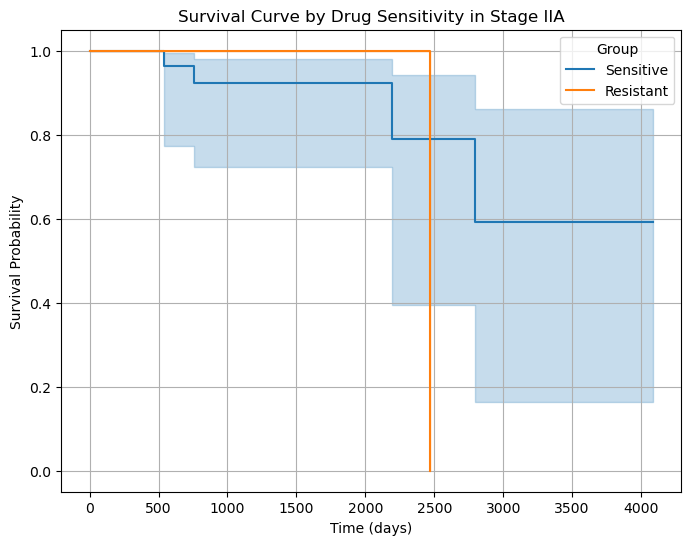

  Log-rank test p-value: 0.6580

Stage: Stage IA


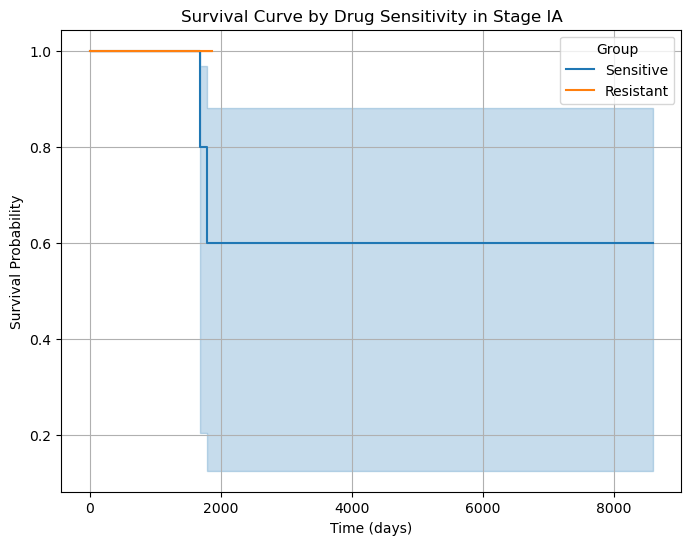

  Log-rank test p-value: 0.5024

Stage: Stage IIIA


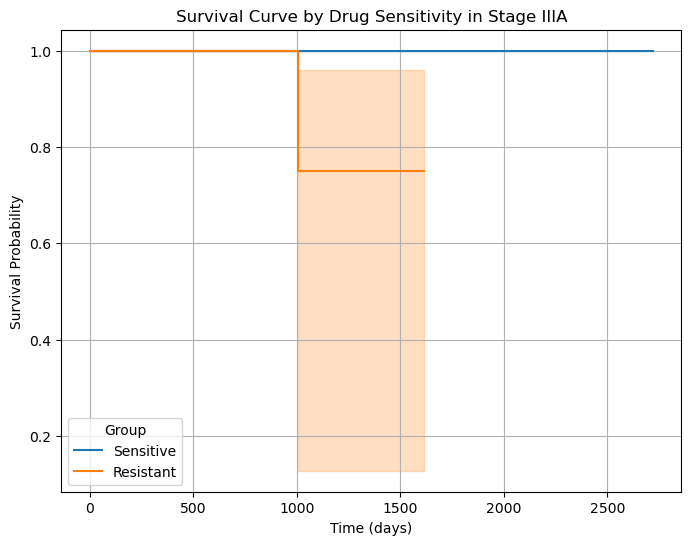

  Log-rank test p-value: 0.3173

Stage: Stage IIIC
  민감군 또는 저항군 데이터가 부족하여 분석 불가.

Stage: Stage IV


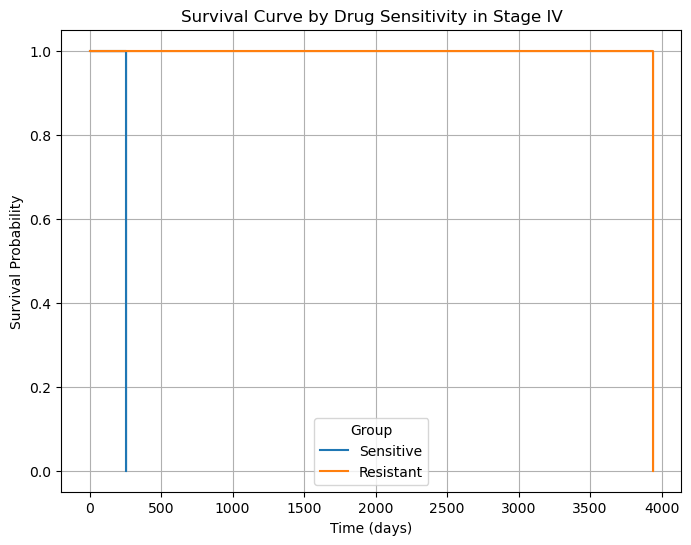

  Log-rank test p-value: 0.3173

Stage: Stage IIIB


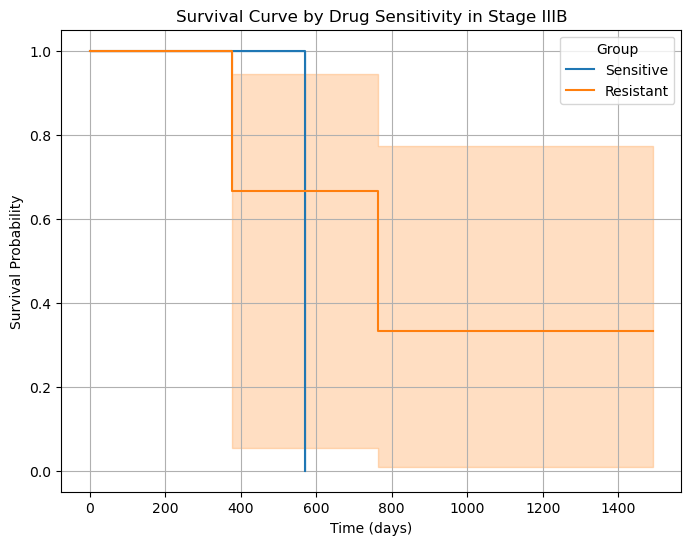

  Log-rank test p-value: 0.6949

Stage: Stage II


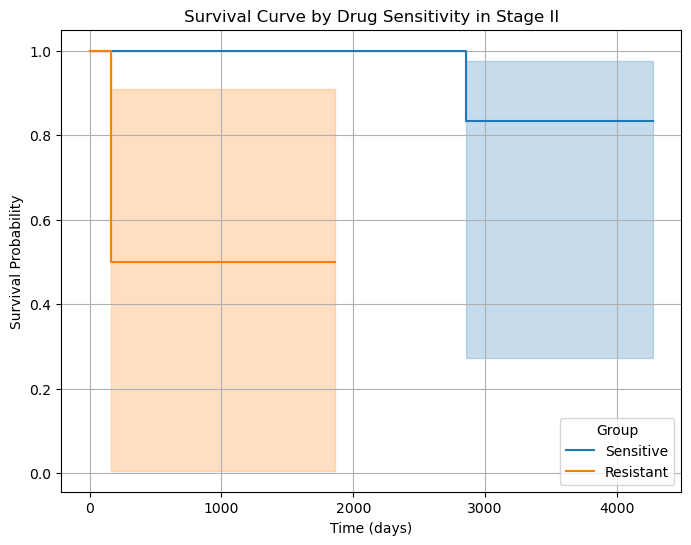

  Log-rank test p-value: 0.0143

Stage: Stage III


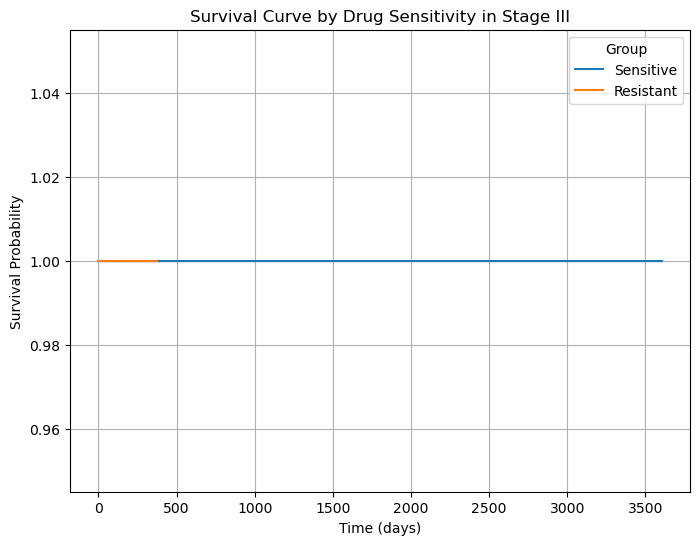

  Log-rank test p-value: 1.0000

Stage: Stage I
  민감군 또는 저항군 데이터가 부족하여 분석 불가.

Stage: Stage X
  민감군 또는 저항군 데이터가 부족하여 분석 불가.

Stage: Stage IB


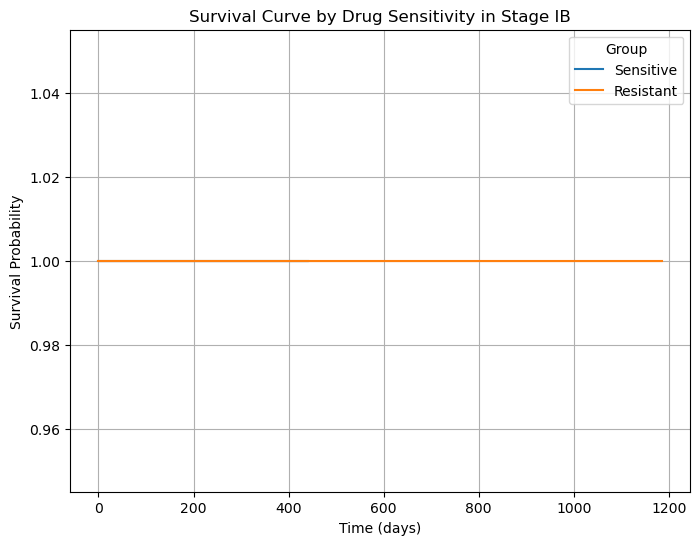

  Log-rank test p-value: 1.0000


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# 필요한 변수 추출 & 결측 제거
survival_data = merged_data_final[['OS.time', 'OS', 'pred', 'AJCC_Stage_nature2012']].dropna()

# 병기별로 분석
stages = survival_data['AJCC_Stage_nature2012'].unique()

for stage in stages:
    print(f"\nStage: {stage}")
    subset = survival_data[survival_data['AJCC_Stage_nature2012'] == stage]
    
    sensitive = subset[subset['pred'] == 1]
    resistant = subset[subset['pred'] == 0]
    
    if len(sensitive) == 0 or len(resistant) == 0:
        print("  민감군 또는 저항군 데이터가 부족하여 분석 불가.")
        continue
    
    # Kaplan-Meier 곡선
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(8,6))
    
    kmf.fit(sensitive['OS.time'], event_observed=sensitive['OS'], label='Sensitive')
    ax = kmf.plot_survival_function(ci_show=True)
    
    kmf.fit(resistant['OS.time'], event_observed=resistant['OS'], label='Resistant')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    plt.title(f'Survival Curve by Drug Sensitivity in {stage}')
    plt.xlabel('Time (days)')
    plt.ylabel('Survival Probability')
    plt.legend(title='Group')
    plt.grid(True)
    plt.show()
    
    # Log-rank 검정
    results = logrank_test(
        sensitive['OS.time'], resistant['OS.time'],
        event_observed_A=sensitive['OS'],
        event_observed_B=resistant['OS']
    )
    print(f'  Log-rank test p-value: {results.p_value:.4f}')

### 분자아형별

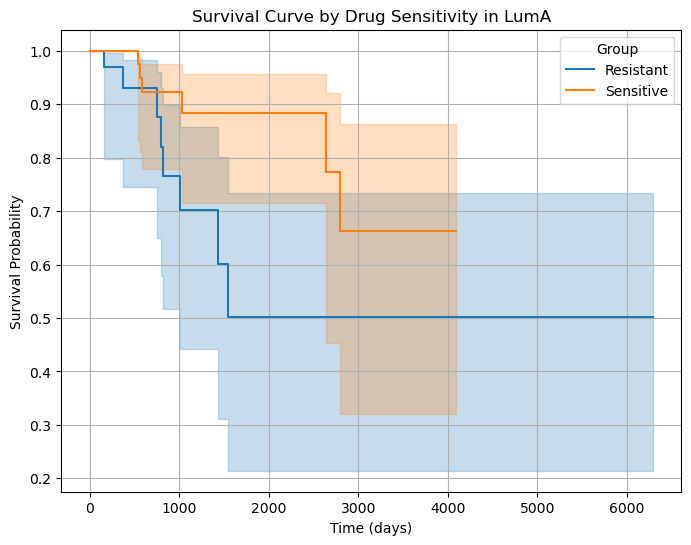

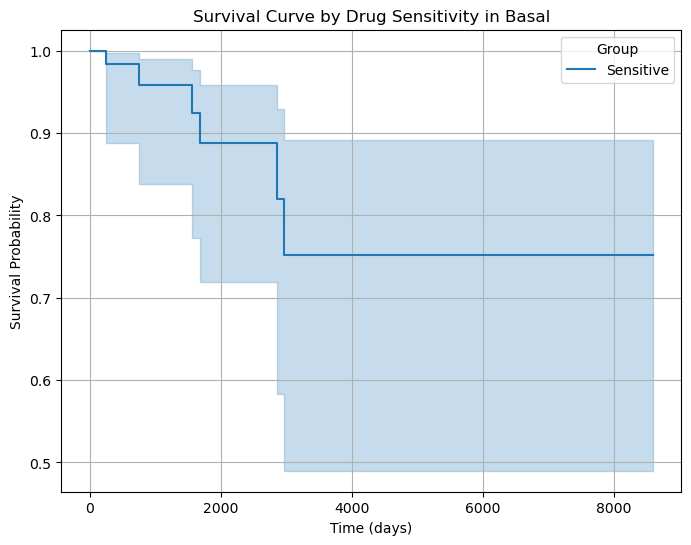

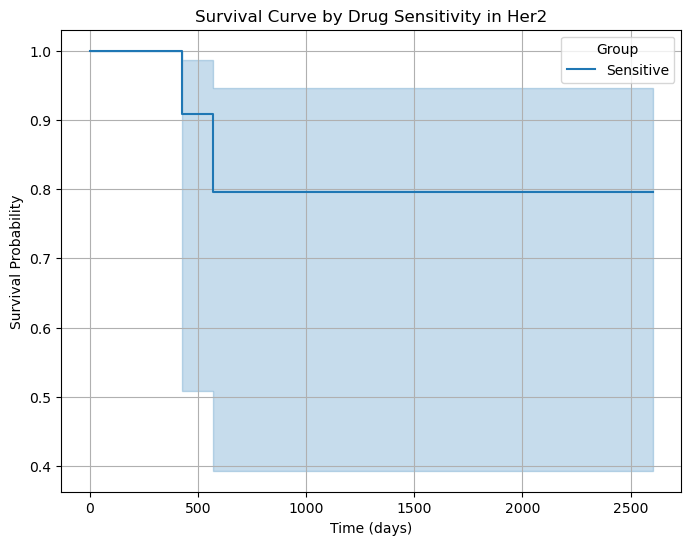

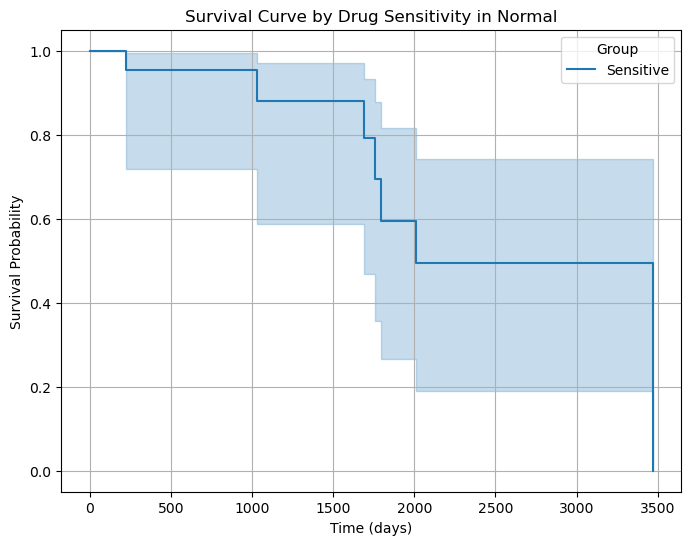

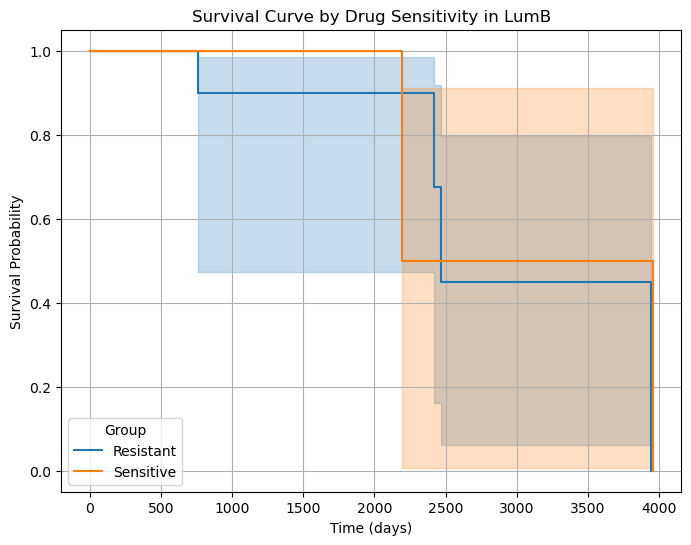

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# 필요한 변수만 추출 & 결측 제거
survival_data = merged_data_final[['OS.time', 'OS', 'pred', 'Subtype_mRNA_y']].dropna()

# 그룹 이름 세팅
subtypes = survival_data['Subtype_mRNA_y'].unique()
 
# 각 분자아형별로 KM곡선 그리기
for subtype in subtypes:
    plt.figure(figsize=(8,6))
    subtype_df = survival_data[survival_data['Subtype_mRNA_y'] == subtype]
    kmf = KaplanMeierFitter()
    
    for label, group_df in subtype_df.groupby('pred'):
        label_name = 'Sensitive' if label == 1 else 'Resistant'
        kmf.fit(group_df['OS.time'], group_df['OS'], label=label_name)
        kmf.plot_survival_function(ci_show=True)
    
    plt.title(f'Survival Curve by Drug Sensitivity in {subtype}')
    plt.xlabel('Time (days)')
    plt.ylabel('Survival Probability')
    plt.legend(title='Group')
    plt.grid(True)
    plt.show()

In [9]:
from lifelines.statistics import logrank_test

# 각 분자아형별로 log-rank test 수행
for subtype in subtypes:
    subtype_df = survival_data[survival_data['Subtype_mRNA_y'] == subtype]
    group_1 = subtype_df[subtype_df['pred'] == 1]
    group_0 = subtype_df[subtype_df['pred'] == 0]
    
    if len(group_1) > 0 and len(group_0) > 0:  # 두 그룹 다 존재할 때만 실행
        results = logrank_test(
            group_1['OS.time'], group_0['OS.time'],
            event_observed_A=group_1['OS'],
            event_observed_B=group_0['OS']
        )
        print(f"{subtype}: Log-rank p-value = {results.p_value:.4f}")
    else:
        print(f"{subtype}: 한쪽 그룹(민감/저항)이 없어서 테스트 불가")

LumA: Log-rank p-value = 0.0378
Basal: 한쪽 그룹(민감/저항)이 없어서 테스트 불가
Her2: 한쪽 그룹(민감/저항)이 없어서 테스트 불가
Normal: 한쪽 그룹(민감/저항)이 없어서 테스트 불가
LumB: Log-rank p-value = 0.5458


암 + 정상 샘플을 모두 가진 환자 수: 1
생존분석에 사용된 고유 환자 수: 227


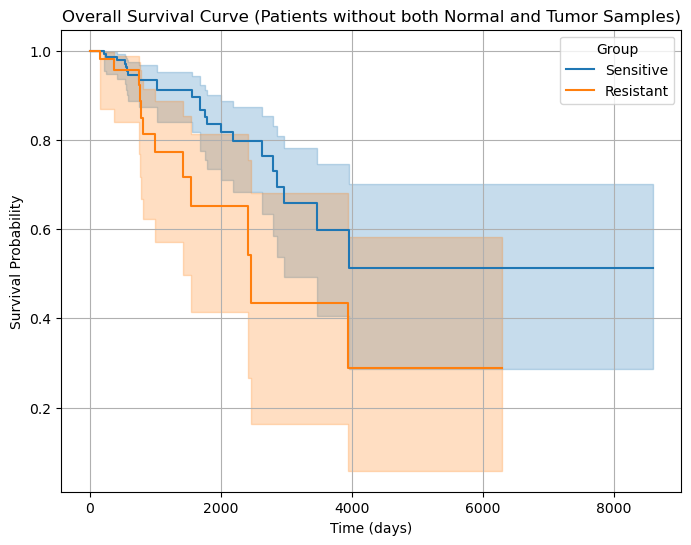

Log-rank test p-value: 0.0155


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# patient_id 추출 (앞 12자리)
merged_data_final['patient_id'] = merged_data_final['sample'].str.slice(0, 12)

# 샘플 타입 추출 (13~14번째 자리)
merged_data_final['sample_type'] = merged_data_final['sample'].str.slice(13, 15)

# 암+정상 둘 다 가진 환자 찾기
patient_samples = merged_data_final.groupby('patient_id')['sample_type'].unique()
patients_with_both = patient_samples[patient_samples.apply(lambda x: ('01' in x) and ('11' in x))].index

# 이 환자들을 제거
filtered_data = merged_data_final[~merged_data_final['patient_id'].isin(patients_with_both)]

print(f"암 + 정상 샘플을 모두 가진 환자 수: {len(patients_with_both)}")
num_patients = filtered_data['patient_id'].nunique()
print(f'생존분석에 사용된 고유 환자 수: {num_patients}')

# 필요한 변수만 추출 & 결측 제거
survival_data = filtered_data[['OS.time', 'OS', 'pred']].dropna()

# 민감군과 저항군 나누기
sensitive = survival_data[survival_data['pred'] == 1]
resistant = survival_data[survival_data['pred'] == 0]

# Kaplan-Meier 곡선
kmf = KaplanMeierFitter()

plt.figure(figsize=(8,6))

# 민감군
kmf.fit(sensitive['OS.time'], event_observed=sensitive['OS'], label='Sensitive')
ax = kmf.plot_survival_function(ci_show=True)

# 저항군
kmf.fit(resistant['OS.time'], event_observed=resistant['OS'], label='Resistant')
kmf.plot_survival_function(ax=ax, ci_show=True)

plt.title('Overall Survival Curve (Patients without both Normal and Tumor Samples)')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.legend(title='Group')
plt.grid(True)
plt.show()

# Log-rank 검정
results = logrank_test(
    sensitive['OS.time'], resistant['OS.time'],
    event_observed_A=sensitive['OS'], event_observed_B=resistant['OS']
)

print(f'Log-rank test p-value: {results.p_value:.4f}')  